# First: Setup AWS variables

In [1]:
# Import libraries
import os 
import boto3
import re
import urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from sklearn.datasets import dump_svmlight_file
from time import strftime
import sys
import math
import json
import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.serializers import CSVSerializer

In [2]:
# set up bucket name, aws role and prefix (xgboots algoritm)
bucket = '1unique-1bucket-1name12345'
role = get_execution_role()
prefix = 'xgboost'
sess = sagemaker.Session()

# Second: Load Data 

In [ ]:
# Download the data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip    
!y

In [3]:
# Read data into DF
data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# Third: Data Cleaning and Exploration

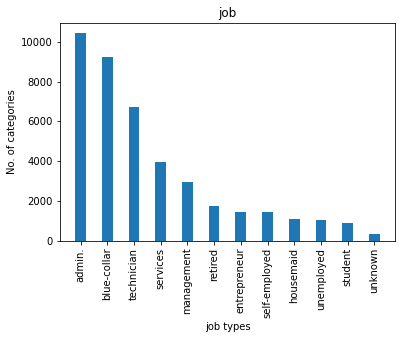

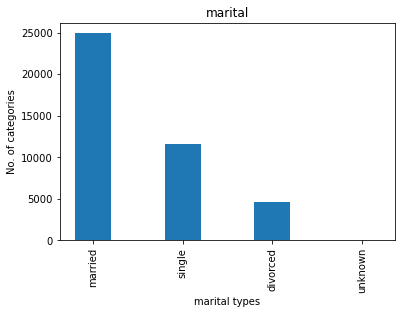

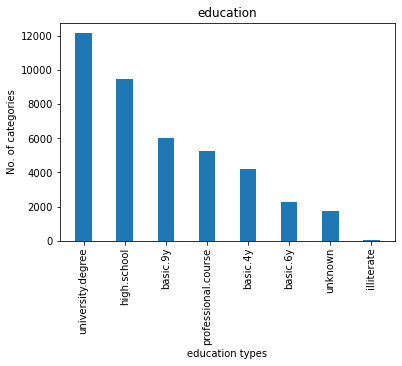

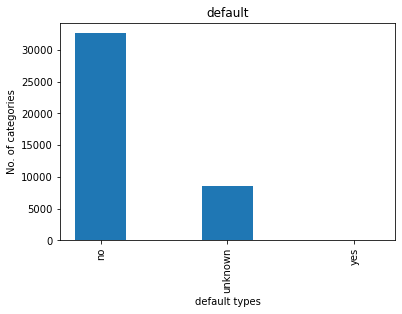

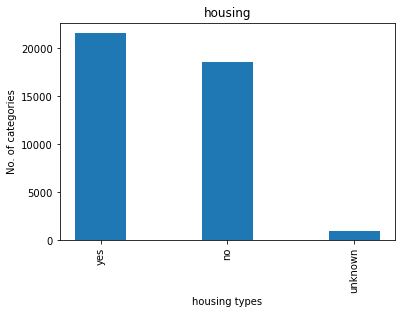

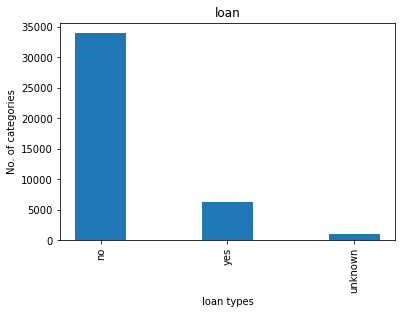

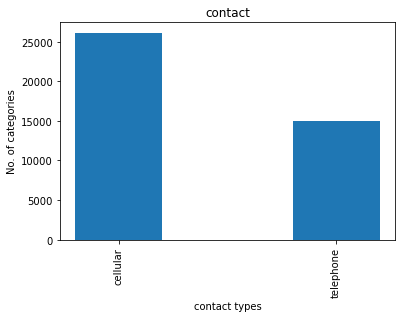

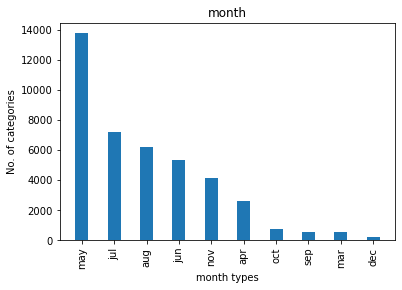

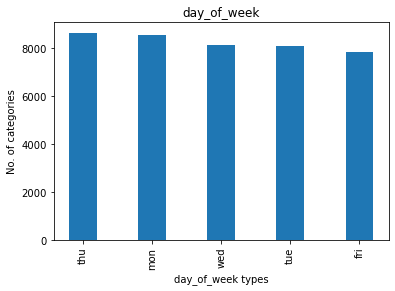

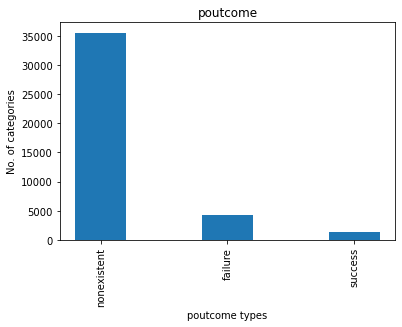

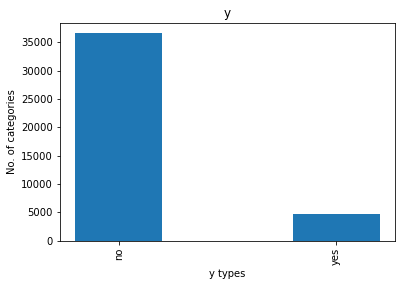

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


UsageError: Line magic function `%matplotlib.inline` not found.


In [4]:
# Frequency tables for categorical features
for column in data.select_dtypes(include=['object']).columns:
    df = pd.DataFrame(data[column].value_counts())
    plt.bar(df.index, df[column],width = 0.4)
    plt.xlabel("%s types"%column)
    plt.ylabel("No. of categories")
    plt.title("%s"%column)
    plt.xticks(rotation=90)
    plt.show()
    
# Histograms for each numeric feature
display(data.describe())
%matplotlib.inline
hist = data.hist(bins=30, sharey=True,figsize=(10,10))

In [5]:
display(data.corr())

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [6]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed
model_data = pd.get_dummies(data)   

In [7]:
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

In [8]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

In [9]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [10]:
sess.upload_data(path='train.csv', bucket=bucket, key_prefix=prefix+'/train/train.csv')
sess.upload_data(path='validation.csv', bucket=bucket, key_prefix=prefix+'/validation/validation.csv')

's3://1unique-1bucket-1name12345/xgboost/validation/validation.csv/validation.csv'

# Fourth: Training Data

In [11]:
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.2-1' )

In [12]:
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [13]:
xgb = Estimator(container,
                role,
                instance_count=1,
                instance_type='ml.m4.xlarge',
                output_path='s3://{}/{}/output'.format(bucket, prefix))

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-05-04 17:24:40 Starting - Starting the training job...
2021-05-04 17:25:04 Starting - Launching requested ML instancesProfilerReport-1620149080: InProgress
.........
2021-05-04 17:26:25 Starting - Preparing the instances for training.........
2021-05-04 17:28:05 Downloading - Downloading input data
2021-05-04 17:28:05 Training - Downloading the training image......
2021-05-04 17:29:12 Uploading - Uploading generated training model
2021-05-04 17:29:12 Completed - Training job completed
[2021-05-04 17:28:55.383 ip-10-0-250-165.us-west-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Deter

# Hosting the end point

In [24]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------------!

# Evaluation

In [25]:
# Simple evaluation no cross validation applied

In [26]:
xgb_predictor.serializer = CSVSerializer()

In [27]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy())

In [28]:
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


predictions,0.0,1.0
actuals,,
0,3587,49
1,387,96
